# Image exploration using Python - essentials
1. Read image from web
2. Querying image: matrix, sub-matrices, ROI
3. Image transformations: filtering
4. Immunohistochemistry example from scikit-image
5. Segmentation and feature extraction 
6. Save information as a xls file 
7. Simulating 2D images - "cells"
8. Simulate particles
9. Check particle neighborhood: groups (clustering algorithms)
10. Pandas and Seaborn

## 1. Read image from web and scikit-image

In [1]:
%matplotlib inline
import numpy as np

from matplotlib import pyplot as plt
from skimage import data, io

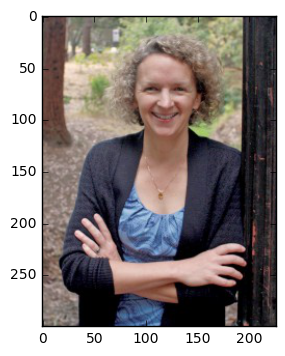

In [2]:
fname = 'http://crl.berkeley.edu/files/2014/04/Holly-226x300.jpg'
imageFromWeb = data.imread(fname, as_grey=False, plugin=None, flatten=None)
plt.imshow(imageFromWeb)

## 2. Querying image: matrix, sub-matrices, ROI

In [3]:
print('-----------------------------------------------------------------------')
print('Image shape is',imageFromWeb.shape, 'and type is',type(imageFromWeb))
print('Min =',imageFromWeb.min(),",Mean =",imageFromWeb.mean(),',Max = ',imageFromWeb.max())
print('dtype = ',imageFromWeb.dtype)
print('-----------------------------------------------------------------------')      

-----------------------------------------------------------------------
Image shape is (300, 226, 3) and type is <class 'numpy.ndarray'>
Min = 0 ,Mean = 97.459906588 ,Max =  255
dtype =  uint8
-----------------------------------------------------------------------


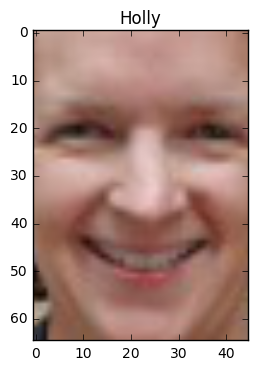

In [4]:
# Cropping an image
facecolor = imageFromWeb[50:115, 95:140]
plt.imshow(facecolor)
plt.title('Holly')

## 3. Image transformations

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.filters.rank import mean, equalize

from skimage.morphology import disk
from skimage import exposure
from skimage.morphology import reconstruction
from skimage import img_as_ubyte, img_as_float

/Users/ushizima/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


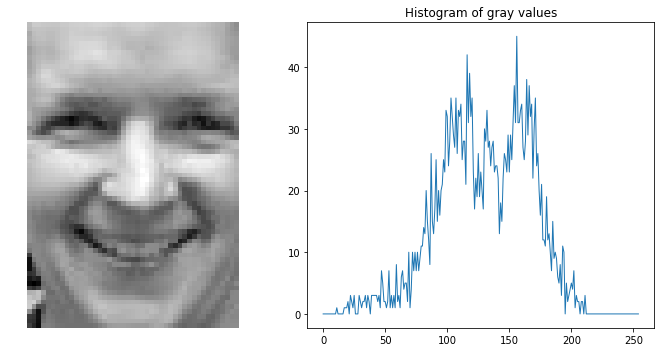

In [6]:
# Turn color image into grayscale representation
face = rgb2gray(facecolor)
face = img_as_ubyte(face) #this generates the warning

hist = np.histogram(face, bins=np.arange(0, 256))

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(face, interpolation='nearest', cmap=plt.cm.gray)
ax[0].axis('off')
                
ax[1].plot(hist[1][:-1], hist[0], lw=1)
ax[1].set_title('Histogram of gray values')

plt.tight_layout()

In [7]:
# Smoothing
smoothed = img_as_ubyte(mean(face, disk(2)))

#smoothPill = ndi.median_filter(edgesPill.astype(np.uint16), 3)
# Global equalization
equalized = exposure.equalize_hist(face)

# Extract edges
edge_sobel = sobel(face)

# Masking
mask = face < 80
facemask = face.copy()
# Set to "white" (255) pixels where mask is True
facemask[mask] = 255
#facemask = img_as_uint(facemask)


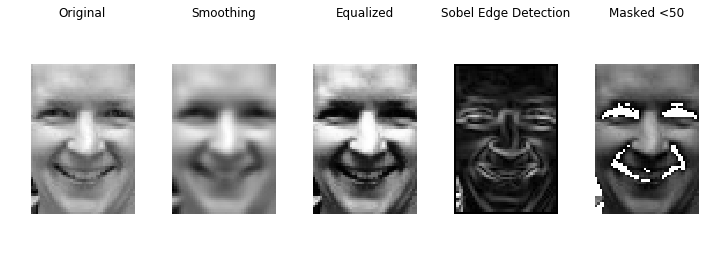

In [8]:
fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True,
                       figsize=(10, 4))

ax[0].imshow(face, cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(smoothed, cmap='gray')
ax[1].set_title('Smoothing')

ax[2].imshow(equalized, cmap='gray')
ax[2].set_title('Equalized')

ax[3].imshow(edge_sobel, cmap='gray')
ax[3].set_title('Sobel Edge Detection')

ax[4].imshow(facemask, cmap='gray')
ax[4].set_title('Masked <50')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

## 4. Immunohistochemistry example from scikit-image
- More at: http://scikit-image.org/docs/dev/api/skimage.data.html#skimage.data.immunohistochemistry

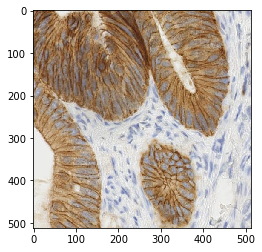

In [9]:
imgMicro = data.immunohistochemistry()
plt.imshow(imgMicro)

# 5. Segmentation and feature extraction

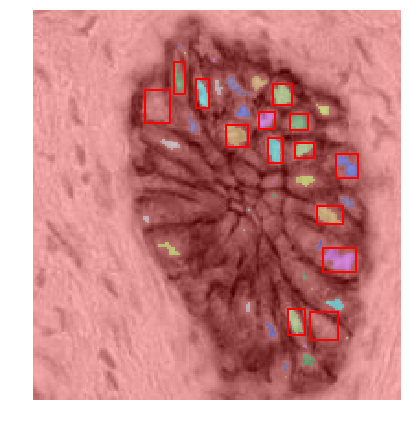

In [10]:
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

# create a subimage for tests
image = imgMicro[300:550, 200:400, 2]

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=image)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 50:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()
#plt.imshow(bw,cmap=plt.cm.gray)  

## 6. Save information as a xls file

In [11]:
# Calculate regions properties from label_image
regions = regionprops(label_image) 

for i in range(len(regions)):
    all_props = {p:regions[i][p] for p in regions[i] if p not in ('image','convex_image','filled_image')}
    for p, v in list(all_props.items()):
        if isinstance(v,np.ndarray):
            if(len(v.shape)>1):
                del all_props[p]

    for p, v in list(all_props.items()):
        try:
            L = len(v)
        except:
            L = 1
        if L>1:
            del all_props[p]
            for n,entry in enumerate(v):
                all_props[p + str(n)] = entry

    k = ", ".join(all_props.keys())
    v = ", ".join([str(f) for f in all_props.values()]) #notice you need to convert numbers to strings
    if(i==0):
        with open('cellsProps.csv','w') as f:
                #f.write(k)
                f.writelines([k,'\n',v,'\n'])       
    else:
        with open('cellsProps.csv','a') as f:
            #f.write(k)
            f.writelines([v,'\n'])         
                

## 7. Simulating 2D images - "cells"

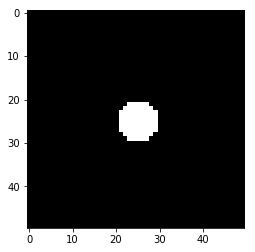

In [12]:
# Test
from skimage.draw import circle
img = np.zeros((50, 50), dtype=np.uint8)
rr, cc = circle(25, 25, 5)
img[rr, cc] = 1
plt.imshow(img,cmap='gray')


In [13]:
%matplotlib inline
import numpy as np

import random
import math
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from skimage import data, io
from skimage.draw import circle

def createMyCells(width, height, r, num_cells):
    
    image = np.zeros((width,height),dtype=np.uint8)
    imgx, imgy = image.shape
    nx = []
    ny = []
    ng = []
    
    #Creates a synthetic set of points
    for i in range(num_cells):
        nx.append(random.randrange(imgx))
        ny.append(random.randrange(imgy))
        ng.append(random.randrange(256))
        
    #Uses points as centers of circles            
    for i in range(num_cells):
        rr, cc = circle(ny[i], nx[i], radius)
        if valid(ny[i],r,imgy) & valid(nx[i],r,imgx):
            image[rr, cc] = ng[i]
    return image

def valid(v,radius,dim):
    if v<radius:
        return False
    else: 
        if v>=dim-radius:
            return False
        else:
            return True

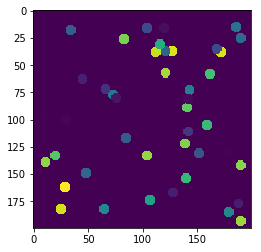

In [14]:
width = 200
height = 200
radius = 5
num_cells = 50
image = createMyCells(width, height, radius, num_cells)
plt.imshow(image)

## 8. Simulate particles with Scikit-learn -> sklearn

In [15]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

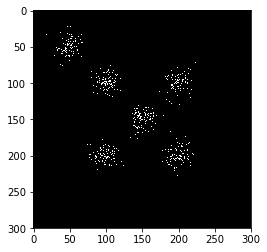

In [16]:
n = 1000
clusterSD = 10 #proportional to the pool size
centers = [[50,50], [100, 100], [100, 200], [150,150], [200, 100], [200,200]]
X, _ = make_blobs(n_samples=n, centers=centers, cluster_std=clusterSD)
image = np.zeros(shape=(300,300), dtype=np.uint8)
for i in X:
    x,y=i.astype(np.uint8)
    #print(x,',',y)
    image[x,y]=255
plt.imshow(image,cmap=plt.cm.gray)    

In [17]:
myquantile=0.15 #Change this parameter (smaller numbers will produce smaller clusters and more numerous)

bandwidth = estimate_bandwidth(X, quantile=myquantile, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 6


## 9. Check particle neighborhood: groups (clustering algorithms)

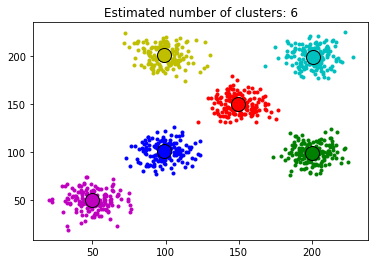

In [18]:
import matplotlib.pyplot as plt
from itertools import cycle 

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## 10. Pandas and seaborn
### Pandas: http://pandas.pydata.org/
### Seaborn: http://seaborn.pydata.org/

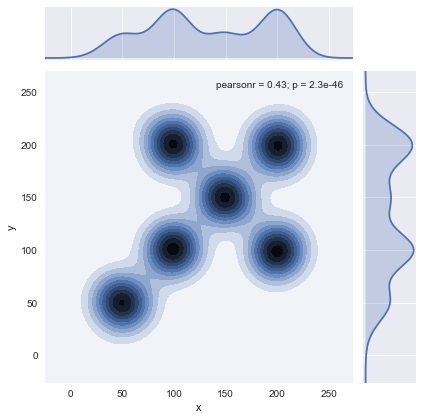

In [19]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(X, columns=["x", "y"])
# Kernel density estimation
sns.jointplot(x="x", y="y", data=df, kind="kde");

# Acknowledgements:
- [A crash course on NumPy for images](http://scikit-image.org/docs/dev/user_guide/numpy_images.html)
